# Why Post-Training Matters

You've probably used ChatGPT or Claude. They answer questions, help with code, refuse to write malware.

But the base model. the one that comes straight out of pre-training. Doesn't do any of that naturally. It just predicts the next word based on internet text.

This notebook explains the gap between "predicting text" and "being helpful," and why closing that gap matters so much.

## The Pre-Training Gap

A pre-trained language model has already learned an incredible amount. It knows grammar, facts about the world, how to write code, even how to reason through problems. It absorbed all of this from billions of words of text.

But. and this is crucial. it learned by playing a simple game: **predict the next word**.

That's it. Given some text, what word comes next?

This is powerful, but it creates a fundamental mismatch:

**Pre-training teaches:** Given text, predict what comes next  
**Users actually want:** Given a question, provide a helpful answer

When you ask a base model "What's the capital of France?", it doesn't think "oh, they want an answer." It thinks "what text usually follows this pattern?"

Sometimes that's a good answer. Sometimes it's not.

## What Pre-Trained Models Actually Learn (The Math)

Let's get specific. Pre-training optimizes this objective:

$$\mathcal{L}_{\text{pretrain}} = -\sum_{t} \log P(x_t | x_{<t})$$

Okay, what does that actually mean? Let's break it down symbol by symbol:

- **$\mathcal{L}_{\text{pretrain}}$**: The pre-training loss (what we're trying to minimize). Lower is better.
- **$\sum_{t}$**: Sum over all positions $t$ in the text (every word/token)
- **$x_t$**: The actual token at position $t$ (what the text really says)
- **$x_{<t}$**: All the tokens before position $t$ (the context so far)
- **$P(x_t | x_{<t})$**: The probability the model assigns to the correct next token, given the context
- **$\log$**: We take the log of that probability (math reasons. makes the optimization nicer)
- **$-$**: We negate it, so minimizing loss = maximizing the probability of correct predictions

In plain English: **make the model assign high probability to whatever word actually comes next**.

This is brilliant for learning language. But notice what's missing: there's nothing here about being helpful, truthful, or safe. The model just learns to predict **likely** continuations, not **good** ones.

**Example:** If the internet is full of text like "How to hack into..." followed by actual hacking tutorials, well, the model learns that pattern. It's just doing what it was trained to do. predict likely next words.

In [ ]:
# Let's see this in action: Base model vs. instruct-tuned model

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# We'll use GPT-2 as the base model and an instruct-tuned variant
base_model_name = "gpt2"  # Standard GPT-2, trained only on next-token prediction
instruct_model_name = "databricks/dolly-v2-3b"  # Instruction-tuned model

print("Loading models (this may take a moment)...")
print()

# Load base model
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
base_tokenizer.pad_token = base_tokenizer.eos_token

# Load instruct model
instruct_tokenizer = AutoTokenizer.from_pretrained(instruct_model_name)
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_name)
instruct_tokenizer.pad_token = instruct_tokenizer.eos_token

# Test prompts
prompts = [
    "What is the capital of France?",
    "Write a haiku about coding.",
    "Explain what recursion is."
]

print("=" * 70)
print("BASE MODEL vs. INSTRUCT-TUNED MODEL")
print("=" * 70)

for i, prompt in enumerate(prompts, 1):
    print(f"\n{i}. Prompt: \"{prompt}\"")
    print()
    
    # Base model
    base_inputs = base_tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        base_outputs = base_model.generate(
            **base_inputs,
            max_new_tokens=50,
            do_sample=True,
            temperature=0.7,
            pad_token_id=base_tokenizer.eos_token_id
        )
    base_response = base_tokenizer.decode(base_outputs[0], skip_special_tokens=True)
    
    print(f"   Base model (GPT-2) says:")
    print(f"   \"{base_response}\"")
    print(f"   → Continues the text (next-token prediction)")
    print()
    
    # Instruct model
    # Format for instruct models (many use a specific format)
    instruct_prompt = f"### Instruction:\n{prompt}\n\n### Response:\n"
    instruct_inputs = instruct_tokenizer(instruct_prompt, return_tensors="pt")
    with torch.no_grad():
        instruct_outputs = instruct_model.generate(
            **instruct_inputs,
            max_new_tokens=50,
            do_sample=True,
            temperature=0.7,
            pad_token_id=instruct_tokenizer.eos_token_id
        )
    instruct_response = instruct_tokenizer.decode(instruct_outputs[0], skip_special_tokens=True)
    # Extract just the response part
    instruct_response = instruct_response.split("### Response:")[-1].strip()
    
    print(f"   Instruct-tuned model (Dolly) says:")
    print(f"   \"{instruct_response}\"")
    print(f"   → Recognizes the instruction and responds helpfully")
    print()

print("=" * 70)
print("The base model treats prompts as text to continue.")
print("The instruct model understands it should respond to the request.")
print("That's what post-training teaches.")
print("=" * 70)

## Three Problems Post-Training Solves

Post-training isn't just one thing. it addresses three distinct problems. Let's break them down.

### 1. The Format Problem

**Issue:** Pre-trained models don't know they should **respond** to questions rather than **continue** them.

When you type "What's the weather like?", a base model might continue with "What's the weather like in London? What's the weather like in Paris?" because that's a pattern it saw in training data (maybe a quiz or list).

**Solution:** Supervised Fine-Tuning (SFT)

SFT teaches the model the Q&A format using examples like:
- **User:** "What's the weather like?"
- **Assistant:** "I don't have access to real-time weather data, but I can help you understand how to check it!"

After seeing thousands of these examples, the model learns to respond instead of continue.

### 2. The Quality Problem  

**Issue:** Many valid completions exist, but humans prefer some over others.

Ask "Explain quantum computing" and you could get:
- A helpful, clear explanation ✓
- A technically correct but incomprehensible lecture ✗
- A snarky dismissal ✗
- "I don't know" (even though it clearly does) ✗

**Solution:** Reinforcement Learning from Human Feedback (RLHF) or Direct Preference Optimization (DPO)

These techniques train models using human preferences. People rate different responses, and the model learns to produce outputs humans prefer.

### 3. The Safety Problem

**Issue:** The internet contains harmful content. Models trained on it will happily generate harmful content.

This isn't the model being malicious. It's just predicting text patterns. If "How do I hack..." is often followed by hacking tutorials in the training data, the model learns that pattern.

**Solution:** Alignment training (part of RLHF/DPO)

Through post-training, models learn to:
- Refuse harmful requests
- Be honest about limitations
- Avoid generating toxic, biased, or dangerous content

Not perfectly. this is still an active area of research. but much better than base models.

## The Alignment Tax

Okay, here's the tradeoff nobody likes to talk about (but we should).

Post-training isn't free. When you train a model to be helpful and safe, you sometimes sacrifice a bit of raw capability. This is called the "alignment tax."

Think of it like this: a base model will answer **anything**. No filters, no guardrails. Just pure next-token prediction. That includes answering questions it probably shouldn't, but it also means it never refuses to help with legitimate tasks.

An aligned model is more selective. It refuses harmful requests (good!), but sometimes it also refuses things it shouldn't, or gives overly cautious answers (less good).

Here's roughly how it shakes out:

| Capability | Pre-trained Model | After Post-Training | Net Effect |
|-----------|------------------|---------------------|------------|
| Raw knowledge | +++++ | ++++ | Slight decrease |
| Following instructions | + | +++++ | Large increase |
| Safety/Refusals | - | +++++ | Large increase |
| Helpfulness | ++ | ++++ | Moderate increase |
| Creativity (sometimes) | +++++ | +++ | Can decrease |

**The good news:** Modern techniques (like DPO, which we'll implement) minimize this tradeoff. The InstructGPT paper showed that you can actually get **better** at almost everything with good post-training, not worse.

**The key insight:** A model that refuses to help you isn't very useful, but neither is one that cheerfully explains how to build a bomb. The art is finding the right balance.

## The Evidence: InstructGPT Changed Everything

In 2022, OpenAI published a paper that proved post-training really matters: InstructGPT.

The results were striking:

- A **1.3 billion parameter** InstructGPT model outperformed the **175 billion parameter** GPT-3 base model
- Users preferred InstructGPT outputs **85% of the time**
- The model was more truthful and less toxic

Let that sink in: a model 130x smaller, with good post-training, beat the massive base model.

**Why?** Because being helpful matters more than being huge.

GPT-3 knew a ton. it had 175B parameters full of knowledge. But it didn't know how to be an assistant. It would:
- Continue your question instead of answering it
- Generate plausible-sounding nonsense
- Happily produce toxic content

InstructGPT, with way fewer parameters but good alignment training, learned to:
- Actually answer questions
- Admit when it didn't know something
- Refuse harmful requests

This was a watershed moment. It showed that post-training isn't just a nice-to-have. it's essential for useful AI systems.

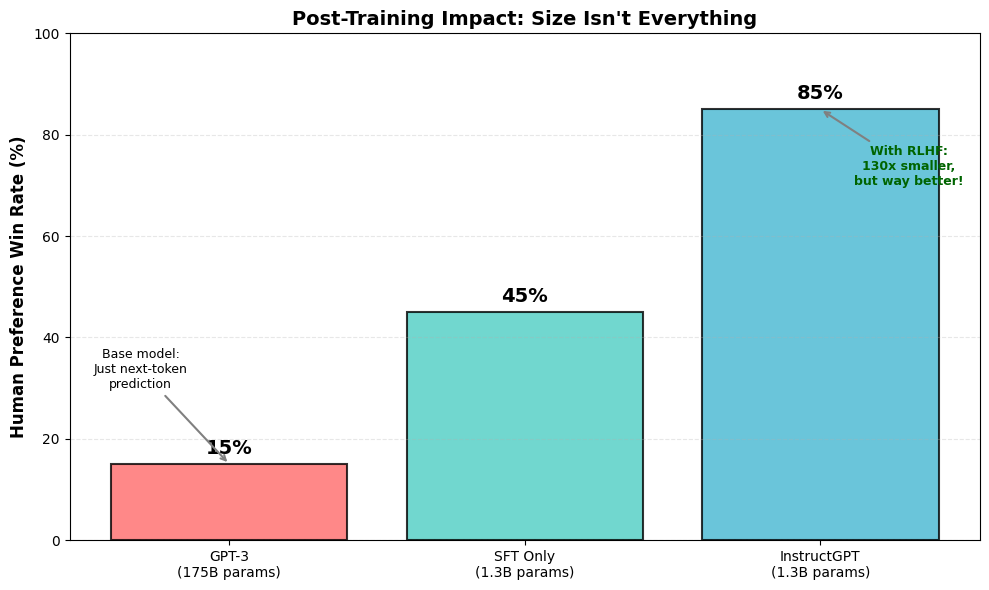


KEY INSIGHT
A 1.3B parameter model with RLHF beats a 175B parameter model without it.

Post-training isn't optional. It's what makes models actually useful.


In [2]:
# Let's visualize the InstructGPT results

import matplotlib.pyplot as plt
import numpy as np

# These are approximate numbers from the InstructGPT paper
models = ['GPT-3\n(175B params)', 'SFT Only\n(1.3B params)', 'InstructGPT\n(1.3B params)']
human_preference = [15, 45, 85]  # Win rate vs GPT-3 baseline
model_colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, human_preference, color=model_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Human Preference Win Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Post-Training Impact: Size Isn\'t Everything', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars, human_preference):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{val}%', ha='center', fontsize=14, fontweight='bold')

# Add annotations
ax.annotate('Base model:\nJust next-token\nprediction', 
            xy=(0, 15), xytext=(-0.3, 30),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
            fontsize=9, ha='center')

ax.annotate('With RLHF:\n130x smaller,\nbut way better!', 
            xy=(2, 85), xytext=(2.3, 70),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
            fontsize=9, ha='center', color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHT")
print("=" * 70)
print("A 1.3B parameter model with RLHF beats a 175B parameter model without it.")
print("\nPost-training isn't optional. It's what makes models actually useful.")
print("=" * 70)

## What We'll Build in This Tutorial Series

Alright, enough theory. Let's talk about what you'll actually implement.

We're going to build the complete post-training pipeline. the same techniques used to create ChatGPT, Claude, and other aligned models. Here's the roadmap:

### 1. Supervised Fine-Tuning (SFT)

We'll start with the basics: teaching a model the Q&A format.

You'll learn:
- How to format instruction data (user/assistant pairs)
- Loss masking (only train on assistant responses, not user prompts)
- Why this alone isn't enough (but it's a critical first step)

**What it does:** Turns "text predictor" into "question answerer"

### 2. Reward Models

Before we can train with human feedback, we need to predict what humans prefer.

You'll learn:
- How to train a model to score responses
- Why we can't just use human ratings directly (spoiler: we need millions of comparisons)
- How one reward model can guide training on billions of examples

**What it does:** Learns to predict "will humans like this response?"

### 3. Reinforcement Learning from Human Feedback (RLHF)

The full algorithm. PPO (Proximal Policy Optimization) with a KL (Kullback-Leibler divergence) penalty.

You'll learn:
- How to use the reward model to guide training
- Why we need a KL penalty (to prevent the model from "hacking" the reward)
- The complete PPO training loop

**What it does:** Optimizes for human preferences while staying close to the original model

### 4. Direct Preference Optimization (DPO)

A simpler, more clean alternative to RLHF that skips the reward model entirely.

You'll learn:
- How to train directly on preference pairs
- Why this works as well as RLHF (or better!)
- When to use DPO vs. RLHF

**What it does:** Same goal as RLHF, but more efficient

---

By the end, you'll understand exactly how models like GPT-4 and Claude go from "impressive but weird" to "actually useful."

Let's get started.

## Next Steps

Now that you understand **why** post-training matters, it's time to see **how** it works.

Head to the next notebook to see the project overview, then we'll look at Supervised Fine-Tuning (SFT). Where you'll train your first aligned model.